In [ ]:
import os
data_dir ='/content/drive/MyDrive/MKS/datasets/jena_climate/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [ ]:
lines[:2]

['01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30',
 '01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10']

In [ ]:
# 넘파이 배열로 변환

import numpy as np

float_data = np.zeros((len(lines), len(header) -1))
for i, line in enumerate(lines):
  values = [float(x) for x in line.split(',')[1:]]
  float_data[i,:] = values

In [ ]:
float_data.shape

(420551, 14)

In [ ]:
float_data[:1]

array([[ 9.96520e+02, -8.02000e+00,  2.65400e+02, -8.90000e+00,
         9.33000e+01,  3.33000e+00,  3.11000e+00,  2.20000e-01,
         1.94000e+00,  3.12000e+00,  1.30775e+03,  1.03000e+00,
         1.75000e+00,  1.52300e+02]])

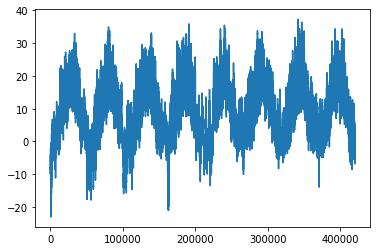

In [ ]:
import matplotlib.pyplot as plt

temp = float_data[:,1]
plt.plot(range(len(temp)),temp)

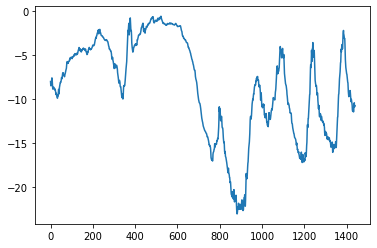

In [ ]:
plt.plot(range(1440), temp[:1440])
plt.show()

In [ ]:
mean= float_data[:200000].mean(axis=0)
std = float_data[:200000].std(axis=0)
float_data -= mean
float_data /=std

In [ ]:
print(float_data[:,1].mean())
print(float_data[:,1].std())

0.04211222174014064
0.9515228544484683


이 제너레이터 함수는 다음과 같은 매개변수가 있습니다:

* `data` : 코드 6-32에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
* `lookback` : 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
* `delay` : 타깃으로 사용할 미래의 타임스텝
* `min_index`와 `max_index` : 추출할 타임스텝의 범위를 지정하기 위한 `data` 배열의 인덱스. 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
* `shuffle` : 샘플을 섞을지 시간 순서대로 추출할지 결정합니다.
* `batch_size` : 배치의 샘플 수
* `step` : 데이터를 샘플링할 타임스텝 간격. 한 시간에 하나의 데이터 포인트를 추출하기 위해 6으로 지정하겠습니다.
* steps_per_epoch * batch_size = 훈련 샘플 수


In [ ]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


In [ ]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback = lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle = True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                      lookback = lookback,
                      delay=delay,
                      min_index=200001,
                      max_index=300000,
                      shuffle = True,
                      step=step,
                      batch_size=batch_size)
test_gen = generator(float_data,
                      lookback = lookback,
                      delay=delay,
                      min_index=300001,
                      max_index=None,
                      shuffle = True,
                      step=step,
                      batch_size=batch_size)

#전체 검증 세트를 순행하기 위해 val_gen에서 추출할 횟수
val_steps = (300000 - 200001 - lookback) // batch_size
# 전체 테스트 세트를 순회하기 위해 test_Gen에서 추출할 룃수
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback//step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


500/500 [==============================] - 10s 18ms/step - loss: 1.6740 - val_loss: 0.7856
Epoch 2/20
500/500 [==============================] - 9s 18ms/step - loss: 0.5542 - val_loss: 0.3310
Epoch 3/20
500/500 [==============================] - 9s 18ms/step - loss: 0.3097 - val_loss: 0.2950
Epoch 4/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2701 - val_loss: 0.3137
Epoch 5/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2549 - val_loss: 0.3546
Epoch 6/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2461 - val_loss: 0.3117
Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2363 - val_loss: 0.3365
Epoch 8/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2325 - val_loss: 0.3307
Epoch 9/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2286 - val_loss: 0.3283
Epoch 10/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2234 - val_loss: 0.3172

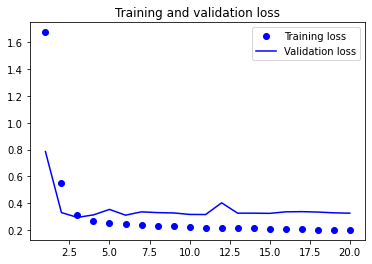

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


결과는 상식적인 수준의 기준점인 MAE 0.29보다 좋지 않다. 그 이유는 해당 모델이 핵심 정보를 찾지 못했기 때문이며 즉 시계열 데이터를 펼쳤기 때문에 시간 개념을 잃어 버렸다. 

[과제] 상기 문제를 해결하기 위하여 순환 시퀀스 처리 모델을 적용하여 데이퍼 포인트의 시간 순서를 사용하여 과제를 수행하세요.(GRU, LSTM)

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import rmsprop_v2

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


500/500 [==============================] - 14s 23ms/step - loss: 0.3016 - val_loss: 0.2714
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2854 - val_loss: 0.2631
Epoch 3/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2790 - val_loss: 0.2691
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2736 - val_loss: 0.2695
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2678 - val_loss: 0.2631
Epoch 6/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2630 - val_loss: 0.2619
Epoch 7/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2577 - val_loss: 0.2650
Epoch 8/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2547 - val_loss: 0.2677
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2504 - val_loss: 0.2667
Epoch 10/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2488 - val_los

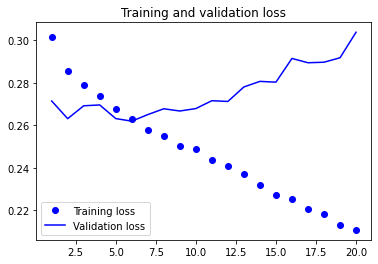

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

[과제] 과대적합을 줄이기 위한 방법을 수행하세요.
 - 순환 드롭아웃
 - 스태킹 순환 층
 - 양방향 RNN사용

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


500/500 [==============================] - 329s 655ms/step - loss: 0.3251 - val_loss: 0.2824
Epoch 2/40
500/500 [==============================] - 325s 651ms/step - loss: 0.3067 - val_loss: 0.2746
Epoch 3/40
500/500 [==============================] - 323s 647ms/step - loss: 0.3012 - val_loss: 0.2694
Epoch 4/40
500/500 [==============================] - 324s 647ms/step - loss: 0.2971 - val_loss: 0.2683
Epoch 5/40
500/500 [==============================] - 323s 646ms/step - loss: 0.2919 - val_loss: 0.2781
Epoch 6/40
500/500 [==============================] - 325s 651ms/step - loss: 0.2882 - val_loss: 0.2677
Epoch 7/40
500/500 [==============================] - 327s 655ms/step - loss: 0.2858 - val_loss: 0.2660
Epoch 8/40
500/500 [==============================] - 327s 654ms/step - loss: 0.2825 - val_loss: 0.2723
Epoch 9/40
500/500 [==============================] - 326s 653ms/step - loss: 0.2777 - val_loss: 0.2789
Epoch 10/40
500/500 [==============================] - 325s 651ms/step - lo

In [2]:
from keras.models import sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

NameError: ignored

In [3]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples[:,::-1,:],targets

train_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step, 
    batch_size=batch_size)
val_gen_reverse = reverse_order_generator(
    float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    step=step,
    batch_size=batch_size)

NameError: ignored

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen_reverse,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen_reverse,
                              validation_steps=val_steps)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models 